In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


### Configuration and Constants

In [2]:
DATA_DIR = '../data/'
FEATURES_FILE = 'features_to_include.csv'
ALL_DATA_FILE = 'all_data.csv'

# Define bins and labels for age categorization
AGE_BINS = [17, 25, 45, 67]
AGE_LABELS = ['18-25', '25-45', '45-67']

# Define real distribution counts for age groups
REAL_DISTR_AGE = np.array([92793, 211801, 159292])

# Define real distribution counts for districts
REAL_COUNTS_DISTRICT = {
    'adres_recentste_wijk_charlois': 70525,
    'adres_recentste_wijk_delfshaven': 77250,
    'adres_recentste_wijk_feijenoord': 79440,
    'adres_recentste_wijk_ijsselmonde': 62670,
    'adres_recentste_wijk_kralingen_c': 56010,
    'adres_recentste_wijk_noord': 52795,
    'adres_recentste_wijk_other': 131855,
    'adres_recentste_wijk_prins_alexa': 97430,
    'adres_recentste_wijk_stadscentru': 42565,
}

RANDOM_STATE = 42

### Helper Functions

In [3]:
def load_features(features_path: str) -> list:
    """Load features to exclude based on the inclusion criteria."""
    features_df = pd.read_csv(features_path, delimiter=';')
    excluded = features_df[features_df['Include'] == 0]['Feature (nl)'].tolist()
    print(f"Number of features to exclude: {len(excluded)}")
    return excluded

def classify_features(df: pd.DataFrame) -> pd.DataFrame:
    """Classify features into Binary, Integer, Continuous, or Unknown."""
    summary = []
    for col in df.columns:
        col_data = df[col].dropna()
        unique_vals = set(col_data.unique())
        is_binary = unique_vals.issubset({0, 1})
        is_integer = np.all(np.equal(np.mod(col_data, 1), 0))
        
        if is_binary:
            feature_type = "Binary"
            details = f"Values: {sorted(unique_vals)}"
        elif is_integer:
            feature_type = "Integer"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        elif not is_integer and col_data.dtype.kind in 'fi':  # float or integer
            feature_type = "Continuous"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        else:
            feature_type = "Unknown"
            details = f"Values: {sorted(unique_vals)}"
        
        summary.append({
            'Feature': col,
            'Type': feature_type,
            'Details': details
        })
    
    return pd.DataFrame(summary)

def scale_features(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    """Scale specified integer features using MinMaxScaler."""
    scaler = MinMaxScaler()
    df[feature_names] = scaler.fit_transform(df[feature_names])
    return df

def calculate_weight_mapping(current_counts: pd.Series, real_counts: np.ndarray) -> dict:
    """Calculate weight mapping based on real distribution."""
    current_proportions = current_counts / current_counts.sum()
    desired_proportions = real_counts / real_counts.sum()
    weight_mapping = desired_proportions / current_proportions.values
    return dict(zip(AGE_LABELS, weight_mapping))

def calculate_district_weights(X_train: pd.DataFrame, district_cols: list, real_counts: dict) -> pd.Series:
    """Calculate and normalize district weights."""
    current_counts = X_train[district_cols].sum()
    current_proportions = current_counts / current_counts.sum()
    real_counts_series = pd.Series(real_counts)
    desired_proportions = real_counts_series / real_counts_series.sum()
    weight_mapping = (desired_proportions / current_proportions).to_dict()
    
    # Assign weights based on district
    district_weights = X_train[district_cols].dot(pd.Series(weight_mapping))
    district_weights = district_weights.replace(0, 1)  # Set weight to 1 for samples with no district info
    return district_weights

def plot_top_features(feature_importance: pd.DataFrame, top_n: int = 30):
    """Plot the top N features based on coefficient magnitude."""
    top_features = feature_importance.head(top_n).iloc[::-1]  # Reverse for better visualization
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Features by Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

### Main Workflow

In [4]:
# Load features to exclude
features_to_exclude = load_features(f"{DATA_DIR}{FEATURES_FILE}")

# Load all data
data = pd.read_csv(f"{DATA_DIR}{ALL_DATA_FILE}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features before exclusion: {data.shape[1]}")

# Drop excluded features
data_copy = data.drop(columns=features_to_exclude)
print(f"Number of features after exclusion: {data_copy.shape[1]}")

# Classify feature types
feature_summary = classify_features(data_copy)

# Find integer features to scale
integer_features = feature_summary[feature_summary['Type'] == 'Integer']['Feature'].tolist()
integer_features = [feat for feat in integer_features if feat != 'persoon_leeftijd_bij_onderzoek']

# Scale integer features
data_copy = scale_features(data_copy, integer_features)

Number of features to exclude: 64
Number of samples: 130000
Number of features before exclusion: 318
Number of features after exclusion: 254


In [5]:
# Prepare features and target
y = data_copy[['Ja', 'checked']]
X = data_copy.drop(['Ja', 'Nee', 'checked'], axis=1).astype(np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

In [6]:
# Handle Age Group Weights
train_age_groups = pd.cut(
    X_train['persoon_leeftijd_bij_onderzoek'],
    bins=AGE_BINS,
    labels=AGE_LABELS,
    right=True
)

current_counts_age = train_age_groups.value_counts().sort_index()
weight_mapping_age = calculate_weight_mapping(current_counts_age, REAL_DISTR_AGE)
sample_weights_age = train_age_groups.map(weight_mapping_age).astype(float)
sample_weights_age_normalized = sample_weights_age / sample_weights_age.mean()

# Drop age column
""" X_train = X_train.drop('persoon_leeftijd_bij_onderzoek', axis=1)
X_test = X_test.drop('persoon_leeftijd_bij_onderzoek', axis=1) """

# Handle District Weights
district_column_names = [col for col in X_train.columns if col.startswith('adres_recentste_wijk_')]
district_weights = calculate_district_weights(X_train, district_column_names, REAL_COUNTS_DISTRICT)
district_weights_normalized = district_weights / district_weights.mean()

# Combine sample weights
combined_sample_weights = sample_weights_age_normalized * district_weights_normalized

In [7]:
# Define and train the logistic regression model
# Define the regularization strength (alpha)
# This can be tuned using cross-validation
ridge_alpha = 1.0  # Example value; you may want to optimize this

# Create a Ridge regressor with the specified alpha
regressor = Ridge(
    alpha=ridge_alpha,
    fit_intercept=True,
    copy_X=True,
    random_state=42
)

pipeline = Pipeline([('regression', regressor)])

pipeline.fit(
    X_train, y_train['Ja'],
    regression__sample_weight=combined_sample_weights
)

threshold = (0.697021996059818 + 0.697013377682873) / 2.0  #approx. boundary value in dataset

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(y_pred)
# print range of values for y_pred
print(f"Minimum value: {y_pred.min()}")
print(f"Maximum value: {y_pred.max()}")

accuracy = accuracy_score(y_test['checked'], y_pred > threshold)
print(f"Model accuracy: {accuracy:.2%}")

[0.6421716  0.53759515 0.5876868  ... 0.5353277  0.53046334 0.55310106]
Minimum value: 0.3214854598045349
Maximum value: 0.9171088933944702
Model accuracy: 89.96%


/Users/matthijsvossen/.local/share/virtualenvs/AI-Testing-33-9R5WRaXh/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.29391e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


/var/folders/yv/gpc5sh7j5k3cls_fv_dpzntc0000gn/T/ipykernel_31152/1450531794.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


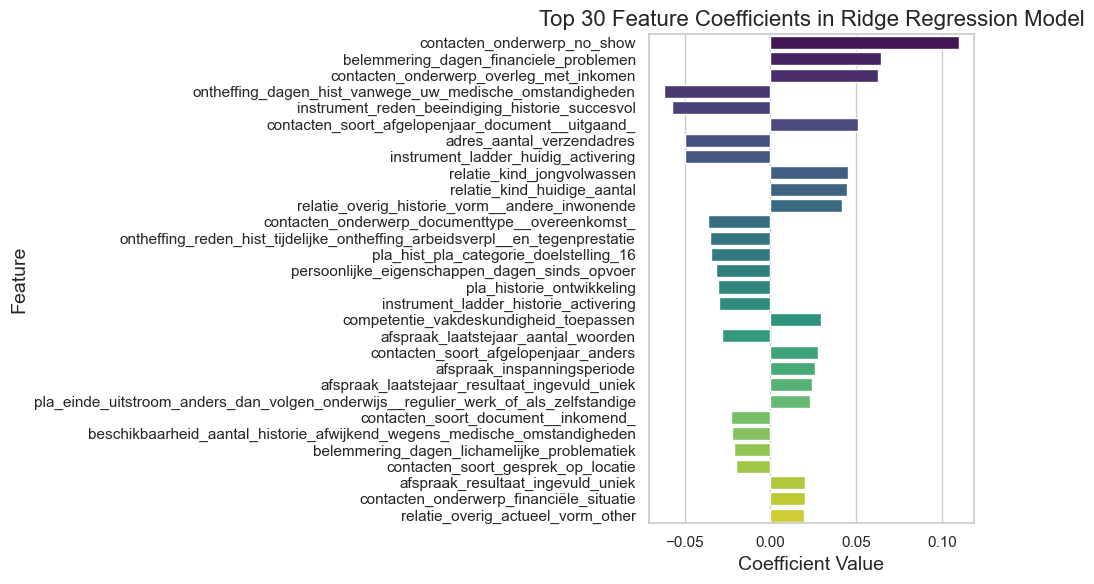

In [8]:
import seaborn as sns

linear_model = pipeline.named_steps['regression']

# Get the coefficients from the model
coefficients = linear_model.coef_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame mapping feature names to their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate absolute coefficients for sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort the DataFrame by absolute coefficient values in descending order
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select the top 30 features
top_30_coef = coef_df_sorted.head(30)

# Optional: Sort the top 30 for better visualization (e.g., ascending order)
#top_30_coef = top_30_coef.sort_values(by='Coefficient')

# Set the plot style for better aesthetics
sns.set_theme(style='whitegrid')

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=top_30_coef,
    palette='viridis'
)

# Add title and labels
plt.title('Top 30 Feature Coefficients in Ridge Regression Model', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

### Store to ONNX

In [9]:
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import convert_sklearn
from onnx import helper
import onnxruntime as rt
import onnx

In [10]:
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

In [11]:
# Add note to onnx graph such that it saves both the predicted risk value
# and the 'checked' value based on if the risk value is higher than the
# provided threshold.

graph = onnx_model.graph
threshold_node = helper.make_node(
    "Constant",
    inputs=[],
    outputs=["threshold"],
    value=helper.make_tensor("value", onnx.TensorProto.FLOAT, [], [threshold])
)
graph.node.append(threshold_node)

greater_node = helper.make_node(
    "Greater",
    inputs=[graph.output[0].name, "threshold"],
    outputs=["boolean_output"]
)
graph.node.append(greater_node)

boolean_output = helper.make_tensor_value_info("boolean_output", onnx.TensorProto.BOOL, [None])
graph.output.extend([boolean_output])

In [12]:
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

# y_pred_onnx[0] = risk values
# y_pred_onnx[1] = boolean value indicating if high risk or not
accuracy_onnx_model = accuracy_score(y_test['checked'], y_pred_onnx[1])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.8995692307692308


2024-12-11 12:43:22.164017 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. 'boolean_output' source:{-1,1} target:{-1}. Falling back to lenient merge.


In [14]:
onnx.save(onnx_model, "../model/ridge_regression_model.onnx")